# Adjoint analysis of a multi-layer slab


> Note: native autograd support is an experimental feature in tidy3d 2.7. To see the original implementation of this notebook using jax and the adjoint plugin, refer to [this notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin2GradientChecking/).

In this notebook, we will show how to differentiate with respect to `DiffractionMonitor` outputs in `tidy3d` and also check the gradient values against gradients obtained using transfer matrix method (TMM), validating their accuracy for a multilayer slab problem.

In [1]:
import numpy as np
import autograd as ag
import autograd.numpy as anp
import tmm
import matplotlib.pyplot as plt
from typing import Tuple, List

import tidy3d as td
import tidy3d.web as web

First, we define some global parameters describing the transmission through a multilayer slab with some spacing between each slab.

The layout is diagrammed below.

<img src="img/AdjointMultilayer.png" width=800 alt="Schematic of the multilayer slab">


In [2]:
# frequency we want to simulate at
freq0 = 2.0e14
k0 = 2 * np.pi * freq0 / td.C_0
freqs = [freq0]
wavelength = td.C_0 / freq0

# background permittivity
bck_eps = 1.0**2

# space between each slab
spc = 0.0

# slab permittivities and thicknesses
slab_eps0 = [2.0**2, 1.8**2, 1.5**2, 1.9**2]
slab_ds0 = [0.5, 0.25, 0.5, 0.5]

# incidence angle
theta = 0 * np.pi / 8

# resolution
dl = 0.01

## Transfer Matrix Method (Ground Truth)

Next we use the `tmm` package to write a function to return the transmission `T` of `p` polarized light given a set of slab permittivities and thicknesses. We'll also write a function to compute the numerical gradient using TMM and will take these to be our "ground truths" when evaluating the accuracy of our values obtained through FDTD and autograd.

### Transmission Calculation with TMM

First, we write a function to compute transmission.

In [3]:
def compute_T_tmm(slab_eps=slab_eps0, slab_ds=slab_ds0) -> float:
    """Get transmission as a function of slab permittivities and thicknesses."""

    # construct lists of permittivities and thicknesses including spaces between
    new_slab_eps = []
    new_slab_ds = []
    for eps, d in zip(slab_eps, slab_ds):
        new_slab_eps.append(eps)
        new_slab_eps.append(bck_eps)
        new_slab_ds.append(d)
        new_slab_ds.append(spc)
    slab_eps = new_slab_eps[:-1]
    slab_ds = new_slab_ds[:-1]

    # add the input and output spaces to the lists
    eps_list = [bck_eps] + slab_eps + [bck_eps]
    n_list = np.sqrt(eps_list)
    d_list = [np.inf] + slab_ds + [np.inf]

    # compute transmission with TMM
    return tmm.coh_tmm("p", n_list, d_list, theta, wavelength)["T"]

We run this function with our starting parameters and see that we get a transmission of about 98% for the set of input parameters.

In [4]:
T_tmm = compute_T_tmm(slab_eps=slab_eps0, slab_ds=slab_ds0)
print(f"T (tmm) = {T_tmm:.3f}")

T (tmm) = 0.786


### Numerical Gradient with TMM

Next, we will use our `compute_T_tmm()` function to compute the "numerical" gradient to use as comparison against our adjoint results with FDTD.

The derivative of a function $f(x)$ w.r.t. $x$ can be approximated using finite differences as

$$ \frac{df}{dx}(x) \approx \frac{f(x+\Delta) - f(x-\Delta)}{2\Delta}$$

with a small step $\Delta$.

To compute the gradient of our transmission with respect to each of the slab thicknesses and permittivities, we need to repeat this step for each of the values. Luckily, since TMM is very fast, we can compute these quantities quite quickly compared to if we were using FDTD.

> Important note: We assume in our TMM numerical gradient that when the slabs are touching (`spc=0`) and a slab thickness is modified, that the thicknesses of the neighboring slabs adjust to accomidate this change. For example, if slab `i` increases by `dt`, slab `i-1` and `i+1` each decrease by `dt/2`. We also account for this in our FDTD set up by keeping the centers of all boxes constant and not tracking the gradient through these quantities. The reason this is required is that `tidy3d` does not recognize the space between touching `td.Box` objects as a single interface and will instead "double count" the gradient contribution of the interface if they are placed right next to each other. One must therefore be careful about overlapping or touching two `td.Box` or other geometries when computing gradients.

Here we write the function to return the numerical gradient.

In [5]:
def compute_grad_tmm(slab_eps=slab_eps0, slab_ds=slab_ds0) -> Tuple[List[float], List[float]]:
    """Compute numerical gradient of transmission w.r.t. each of the slab permittivities and thicknesses using TMM."""

    delta = 1e-4

    # set up containers to store gradient and perturbed arguments
    num_slabs = len(slab_eps)
    grad_tmm = np.zeros((2, num_slabs), dtype=float)
    args = np.stack((slab_eps, slab_ds), axis=0)

    # loop through slab index and argument index (eps, d)
    for arg_index in range(2):
        for slab_index in range(num_slabs):
            grad = 0.0

            # perturb the argument by delta in each + and - direction
            for pm in (-1, +1):
                args_num = args.copy()
                args_num[arg_index][slab_index] += delta * pm

                # NEW: for slab thickness gradient, need to modify neighboring slabs too
                if arg_index == 1 and spc == 0:
                    if slab_index > 0:
                        args_num[arg_index][slab_index - 1] -= delta * pm / 2
                    if slab_index < num_slabs - 1:
                        args_num[arg_index][slab_index + 1] -= delta * pm / 2

                # compute argument perturbed T and add to finite difference gradient contribution
                T_tmm = compute_T_tmm(slab_eps=args_num[0], slab_ds=args_num[1])
                grad += pm * T_tmm / 2 / delta

            grad_tmm[arg_index][slab_index] = grad
    grad_eps, grad_ds = grad_tmm
    return grad_eps, grad_ds

Let's run this function and observe the gradients. These will be saved later to compare against our autograd results.

In [6]:
grad_eps_tmm, grad_ds_tmm = compute_grad_tmm()
print(f"gradient w.r.t. eps (tmm)  = {grad_eps_tmm}")
print(f"gradient w.r.t. ds  (tmm)  = {grad_ds_tmm}")

gradient w.r.t. eps (tmm)  = [-0.2766323   0.01377339 -0.2032054  -0.28999361]
gradient w.r.t. ds  (tmm)  = [-1.75199732 -0.21552416  1.00729645 -2.08209951]


## FDTD

Next, we will implement the same two functions using Tidy3D.

### Transmission Calculation with FDTD

We first write a function to compute the transmission of a multilayer slab using Tidy3D. We use a `DiffractionMonitor` to measure our transmission amplitudes. Below, we break up the transmission calculation into a few functions to make it easier to read and re-use later.

In [31]:
from autograd.tracer import getval

def make_sim(slab_eps=slab_eps0, slab_ds=slab_ds0) -> td.Simulation:
    """Create a Simulation given the slab permittivities and thicknesses."""

    # frequency setup
    wavelength = td.C_0 / freq0
    fwidth = freq0 / 10.0
    freqs = [freq0]

    # geometry setup
    bck_medium = td.Medium(permittivity=bck_eps)

    space_above = 2
    space_below = 2

    length_x = 1.0
    length_y = 1.0
    length_z = space_below + sum(slab_ds0) + space_above + (len(slab_ds0) - 1) * spc
    sim_size = (length_x, length_y, length_z)

    # make structures
    slabs = []
    z_start = -length_z / 2 + space_below
    for d, eps in zip(slab_ds, slab_eps):

        # dont track the gradient through the center of each slab
        # as tidy3d doesn't have enough information to properly process the interface between touching Box objects
        z_center = z_start + d / 2
        z_center = getval(z_center)

        slab = td.Structure(
            geometry=td.Box(center=[0, 0, z_center], size=[td.inf, td.inf, d]),
            medium=td.Medium(permittivity=eps),
        )
        slabs.append(slab)
        z_start = z_start + d + spc

    # source setup
    gaussian = td.GaussianPulse(freq0=freq0, fwidth=fwidth)
    src_z = -length_z / 2 + space_below / 2.0

    source = td.PlaneWave(
        center=(0, 0, src_z),
        size=(td.inf, td.inf, 0),
        source_time=gaussian,
        direction="+",
        angle_theta=theta,
        angle_phi=0,
        pol_angle=0,
    )

    # boundaries
    boundary_x = td.Boundary.bloch_from_source(
        source=source, domain_size=sim_size[0], axis=0, medium=bck_medium
    )
    boundary_y = td.Boundary.bloch_from_source(
        source=source, domain_size=sim_size[1], axis=1, medium=bck_medium
    )
    boundary_spec = td.BoundarySpec(x=boundary_x, y=boundary_y, z=td.Boundary.pml(num_layers=40))

    # monitors
    mnt_z = length_z / 2 - space_above / 2.0
    monitor_1 = td.DiffractionMonitor(
        center=[0.0, 0.0, mnt_z],
        size=[td.inf, td.inf, 0],
        freqs=freqs,
        name="diffraction",
        normal_dir="+",
    )

    # make simulation
    return td.Simulation(
        size=sim_size,
        # grid_spec=td.GridSpec.auto(min_steps_per_wvl=100),
        grid_spec=td.GridSpec.uniform(dl=0.01),
        structures=slabs,
        sources=[source],
        monitors=[monitor_1],
        run_time=10 / fwidth,
        boundary_spec=boundary_spec,
        medium=bck_medium,
        subpixel=True,
        shutoff=1e-8,
    )

Let's generate a simulation and plot it to make sure it looks reasonable.

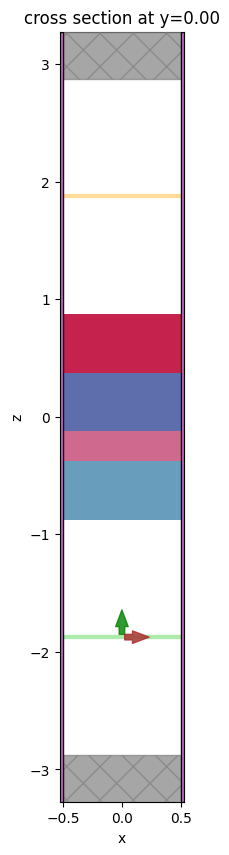

In [32]:
sim = make_sim()
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sim.plot(y=0, ax=ax)
plt.show()

Now we write a function to post process some run results to get the transmission we are after.

In [33]:
def post_process_T(sim_data: td.SimulationData) -> float:
    """Given some td.SimulationData from the run, return the transmission of "p" polarized light."""
    amps = sim_data["diffraction"].amps.sel(polarization="p").values
    return anp.sum(abs(amps) ** 2)

And finally, put everything together in a single function that relates the permittivities and thicknesses of each slab to the transmission, through a `td.Simulation` run.

In [34]:
def compute_T_fdtd(slab_eps=slab_eps0, slab_ds=slab_ds0) -> float:
    """Given the slab permittivities and thicknesses, compute T."""
    sim = make_sim(slab_eps=slab_eps, slab_ds=slab_ds)
    sim_data = web.run(sim, task_name="slab", verbose=True)
    return post_process_T(sim_data)

In [35]:
T_fdtd = compute_T_fdtd(slab_eps0, slab_ds0)
print(T_fdtd)

↓ simulation_data.hdf5.gz ━━━━━━━━━━━━━━━━━━━━ 100.0% • 2.9/2.9 kB • ? • 0:00:00

             loading simulation from simulation_data.hdf5

0.7851624129038903


### Computing T and Gradient with FDTD

Now that we have this function defined, we are ready to compute our transmission and gradients using Tidy3d.

We first call `autograd.value_and_grad()` on our transmission calculation function, which returns a function that will give us both `T` and the gradient of `T` with respect to the input parameters in one shot. For more details, see the previous tutorial.

In [36]:
compute_T_and_grad_fdtd = ag.value_and_grad(compute_T_fdtd, argnum=(0, 1))

Next, we call this function on our starting parameters, which will kick off the original (`fwd`) T transmission simulation and then the reverse (`adj`) simulation, which is used in combination with `fwd` for the gradient calculation.

In [37]:
T_fdtd, (grad_eps_fdtd, grad_ds_fdtd) = compute_T_and_grad_fdtd(slab_eps0, slab_ds0)

↓ simulation_data.hdf5.gz ━━━━━━━━━━━━ 100.0% • 530.7/530.7 • 1.6 MB/s • 0:00:00
                                                kB         

15:31:34 EDT loading simulation from simulation_data.hdf5

### Checking Accuracy of TMM (Numerical) vs FDTD (Adjoint)

Let's convert these from autograd types to numpy arrays to work with them easier, and then display the results compared to TMM.

In [38]:
grad_eps_fdtd = np.array(grad_eps_fdtd)
grad_ds_fdtd = np.array(grad_ds_fdtd)

In [39]:
print(f"T (tmm)  = {T_tmm:.5f}")
print(f"T (FDTD) = {T_fdtd:.5f}")

T (tmm)  = 0.78581
T (FDTD) = 0.78516


We see that the transmission results match very well with TMM, giving us a lot of confidence that our set up is correct.

Let's look at the gradients now.

In [40]:
print("un-normalized:")
print(f"\tgrad_eps (tmm)  = {grad_eps_tmm}")
print(f"\tgrad_eps (FDTD)  = {grad_eps_fdtd}")
print(80 * "-")
print(f"\tgrad_ds  (tmm)  = {grad_ds_tmm}")
print(f"\tgrad_ds  (FDTD)  = {grad_ds_fdtd}")


rms_eps = np.linalg.norm(grad_eps_tmm - grad_eps_fdtd) / np.linalg.norm(grad_eps_tmm)
rms_ds = np.linalg.norm(grad_ds_tmm - grad_ds_fdtd) / np.linalg.norm(grad_ds_tmm)

print(f"RMS error = {rms_eps * 100} %")
print(f"RMS error = {rms_ds * 100} %")

un-normalized:
	grad_eps (tmm)  = [-0.2766323   0.01377339 -0.2032054  -0.28999361]
	grad_eps (FDTD)  = [-0.28169015  0.01413355 -0.2066128  -0.29536529]
--------------------------------------------------------------------------------
	grad_ds  (tmm)  = [-1.75199732 -0.21552416  1.00729645 -2.08209951]
	grad_ds  (FDTD)  = [-1.78417513 -0.21968112  1.02736547 -2.12168249]
RMS error = 1.8095298024231286 %
RMS error = 1.8894452951610317 %


If we only care about the error in the "directions" of the gradients, we can compare their normalized versions to each other.

In [41]:
def normalize(arr):
    return arr / np.linalg.norm(arr)

grad_eps_tmm_norm = normalize(grad_eps_tmm)
grad_ds_tmm_norm = normalize(grad_ds_tmm)
grad_eps_fdtd_norm = normalize(grad_eps_fdtd)
grad_ds_fdtd_norm = normalize(grad_ds_fdtd)

rms_eps = np.linalg.norm(grad_eps_tmm_norm - grad_eps_fdtd_norm) / np.linalg.norm(grad_eps_tmm_norm)
rms_ds = np.linalg.norm(grad_ds_tmm_norm - grad_ds_fdtd_norm) / np.linalg.norm(grad_ds_tmm_norm)

In [42]:
print("normalized:")
print(f"\tgrad_eps (tmm)  = {grad_eps_tmm_norm}")
print(f"\tgrad_eps (FDTD)  = {grad_eps_fdtd_norm}")
print(f"\tRMS error = {rms_eps * 100} %")
print(80 * "-")
print(f"\tgrad_ds  (tmm)  = {grad_ds_tmm_norm}")
print(f"\tgrad_ds  (FDTD)  = {grad_ds_fdtd_norm}")
print(f"\tRMS error = {rms_ds * 100} %")

normalized:
	grad_eps (tmm)  = [-0.61534061  0.03063751 -0.45200988 -0.64506151]
	grad_eps (FDTD)  = [-0.61546283  0.03088029 -0.45142685 -0.64534154]
	RMS error = 0.07015884074927643 %
--------------------------------------------------------------------------------
	grad_ds  (tmm)  = [-0.60214521 -0.07407365  0.34619844 -0.71559827]
	grad_ds  (FDTD)  = [-0.60183674 -0.07410269  0.34655022 -0.71568449]
	RMS error = 0.047663670213745624 %


In which case we see a very good agreement.